# intiial development

In [1]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions, AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from src.rxn_ctr_mcs import *
from src.utils import rxn_entry_to_smarts

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

In [3]:
# Develop rxns -> PRC MCS Index

pred_rxn_sma = 'O=C(O)CCC(CC(=O)O)C(=O)O.\
                NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1\
                >>O=C(O)C=C(CCC(=O)O)C(=O)O.\
                NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

known_rxn_entry = [{'(2R)-2-methylbutanedioic acid:0': 'CC(CC(=O)O)C(=O)O',
                    'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
                    {'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
                    'citraconic acid:0': 'CC(=CC(=O)O)C(=O)O'}]

known_rxn_sma = rxn_entry_to_smarts(known_rxn_entry)

rxn_sma1 = pred_rxn_sma
rxn_sma2 = known_rxn_sma

'''
'''
am_rxn_smarts = [atom_map(rxn_sma1), atom_map(rxn_sma2)] # Atom map

# Construct reaction objects
rxns = []
for elt in am_rxn_smarts:
    temp = AllChem.ReactionFromSmarts(elt, useSmiles=True)
    temp.Initialize()
    rxns.append(temp)

rc_atoms = [elt.GetReactingAtoms() for elt in rxns] # Get reaction center atom idxs

# Construct rxn ctr mol objs
rcs = []
for i, t_rxn in enumerate(rxns):
    temp = []
    for j, t_mol in enumerate(t_rxn.GetReactants()):
        temp.append(get_sub_mol(t_mol, rc_atoms[i][j]))
    rcs.append(temp)

# Align substrates of the 2 reactions
rc_idxs = [] # Each element: (idx for rxn 1, idx for rxn 2)
remaining = [[i for i in range(len(elt))] for elt in rcs]
while (len(remaining[0]) > 0) & (len(remaining[1]) > 0):
    idx_pair = align_substrates(rcs, remaining)

    if idx_pair is None:
        break
    else:
        rc_idxs.append(idx_pair)
        remaining[0].remove(idx_pair[0])
        remaining[1].remove(idx_pair[1])

# Re-label atom map nums in substrate pairs
# so that reaction centers of aligned subs
# take atommapnum from rxn1 arbitrarily
# (Necessary for PRC MCS)
rxns = align_atom_map_nums(rxns, rcs, rc_idxs, rc_atoms)

prc_mcs = get_prc_mcs(rxns, rcs, rc_idxs, rc_atoms) # Compute MCS seeded by reaction center
prc_mcs

[1.0, 0.8888888888888888]

In [7]:
# Test if MCS is hydrogen sensitive

smi1 = '[CH3][CH2][CH2][NH][CH3]'
smi2 = '[CH3][CH2][CH2][NH3+]'
smi1 = 'CCCNC'
smi2 = 'CCCN'

mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)

for atom in mol1.GetAtoms():
    print(atom.GetNumExplicitHs(), ' + ', atom.GetNumImplicitHs(), ' = ', atom.GetTotalNumHs(), ' ?')
    


0  +  3  =  3  ?
0  +  2  =  2  ?
0  +  2  =  2  ?
0  +  1  =  1  ?
0  +  3  =  3  ?


In [10]:
res = rdFMCS.FindMCS((mol1, mol2),
                                atomCompare=rdFMCS.AtomCompare.CompareElements,
                                bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                                matchValences=True
                            )

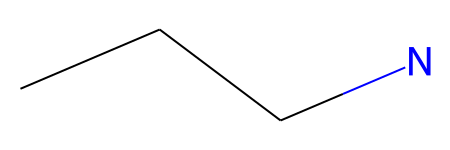

In [11]:
Chem.MolFromSmarts(res.smartsString)

In [12]:
res.smartsString

'[#6]-[#6]-[#6]-[#7]'

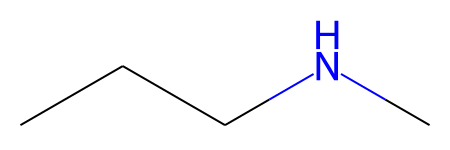

In [13]:
mol1

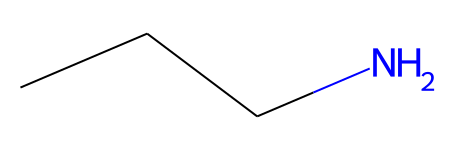

In [14]:
mol2

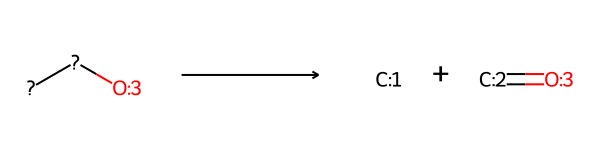

In [31]:
rule_24_40 = '[#6;$([#6&!R](-&!@[#6&!R]=&!@[#8&!R])(-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R])-&!@[#7&!R]);!$([#6&!R](-&!@[#6&!R]=&!@[#8&!R])(-&!@[#7&!R])-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]):1]-[#6;$([#6&!R](-[#6&!R](-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R])-&!@[#7&!R])=[#8&!R]);!$([#6&!R](-[#6&!R](-&!@[#7&!R])-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R])=[#8&!R]):2]-[#8:3]>>[#6:1].[#6:2]=[#8:3]'
AllChem.ReactionFromSmarts(rule_24_40)

In [33]:
rule_24_40.split('.')[0]

'[#6;$([#6&!R](-&!@[#6&!R]=&!@[#8&!R])(-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R])-&!@[#7&!R]);!$([#6&!R](-&!@[#6&!R]=&!@[#8&!R])(-&!@[#7&!R])-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]):1]-[#6;$([#6&!R](-[#6&!R](-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R])-&!@[#7&!R])=[#8&!R]);!$([#6&!R](-[#6&!R](-&!@[#7&!R])-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R])=[#8&!R]):2]-[#8:3]>>[#6:1]'

In [62]:
# Getting started rdkit example

mols = [Chem.MolFromSmiles("CCC1CC2C1CN2"), Chem.MolFromSmiles("C1CC2C1CC2")]


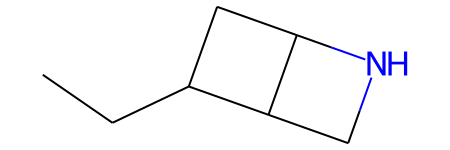

In [66]:
mols[0]

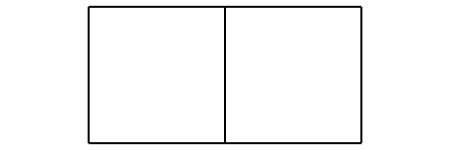

In [67]:
mols[1]

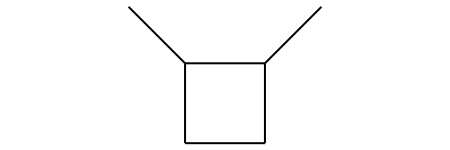

In [68]:

Chem.MolFromSmarts(rdFMCS.FindMCS(mols).smartsString)


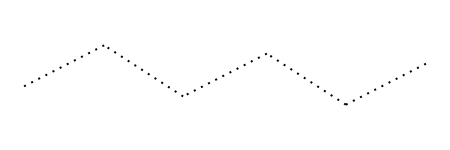

In [69]:

Chem.MolFromSmarts(rdFMCS.FindMCS(mols, ringMatchesRingOnly=True).smartsString)


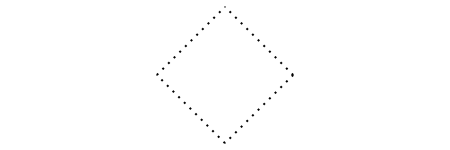

In [71]:

Chem.MolFromSmarts(rdFMCS.FindMCS(mols, completeRingsOnly=True).smartsString)

In [7]:
sma1 = '[8#8:1]=[6#6:2](-[8#8H:3])-[6#6H2:4]-[2970#6H2:5]-[8910#6:15](=[8#8:14])-[8#8H:16]'
sma2 = '[6#6H3:1]-[2970#6H:5](-[6#6:3](=[8#8:4])-[16#16:5]-[6#6H2:6]-[6#6H2:7]-[7#7H:8]-[6#6:9](=[8#8:10])-[6#6H2:11]-[6#6H2:12]-[7#7H:13]-[6#6:14](=[8#8:15])-[6#6H:16](-[8#8H:17])-[6#6:18](-[6#6H3:19])(-[6#6H3:20])-[6#6H2:21]-[8#8:22]-[15#15:23](=[8#8:24])(-[8#8H:25])-[8#8:26]-[15#15:27](=[8#8:28])(-[8#8H:29])-[8#8:30]-[6#6H2:31]-[6#6H:32]1-[8#8:33]-[6#6H:34](-[7#7:35]2:[6#6H:36]:[7#7:37]:[6#6:38]3:[6#6:39](-[7#7H2:40]):[7#7:41]:[6#6H:42]:[7#7:43]:[6#6:44]:2:3)-[6#6H:45](-[8#8H:46])-[6#6H:47]-1-[8#8:48]-[15#15:49](=[8#8:50])(-[8#8H:51])-[8#8H:52])-[8910#6:15](=[8#8:53])-[8#8H:55]'
subs = [Chem.SanitizeMol(Chem.MolFromSmarts(elt)) for elt in [sma1, sma2]]

res = rdFMCS.FindMCS(subs,
                    atomCompare=rdFMCS.AtomCompare.CompareIsotopes,
                    bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                    matchChiralTag=False,
                    ringMatchesRingOnly=True,
                    completeRingsOnly=True,
                    matchValences=True
                            )

AtomValenceException: Explicit valence for atom # 34 N, 4, is greater than permitted

In [15]:
# Chem.SanitizeMol(Chem.MolFromSmarts(sma2))
# Chem.MolFromSmarts(sma2).GetAtomWithIdx(34).GetAtomicNum()
sma2

'[6#6H3:1]-[2970#6H:5](-[6#6:3](=[8#8:4])-[16#16:5]-[6#6H2:6]-[6#6H2:7]-[7#7H:8]-[6#6:9](=[8#8:10])-[6#6H2:11]-[6#6H2:12]-[7#7H:13]-[6#6:14](=[8#8:15])-[6#6H:16](-[8#8H:17])-[6#6:18](-[6#6H3:19])(-[6#6H3:20])-[6#6H2:21]-[8#8:22]-[15#15:23](=[8#8:24])(-[8#8H:25])-[8#8:26]-[15#15:27](=[8#8:28])(-[8#8H:29])-[8#8:30]-[6#6H2:31]-[6#6H:32]1-[8#8:33]-[6#6H:34](-[7#7:35]2:[6#6H:36]:[7#7:37]:[6#6:38]3:[6#6:39](-[7#7H2:40]):[7#7:41]:[6#6H:42]:[7#7:43]:[6#6:44]:2:3)-[6#6H:45](-[8#8H:46])-[6#6H:47]-1-[8#8:48]-[15#15:49](=[8#8:50])(-[8#8H:51])-[8#8H:52])-[8910#6:15](=[8#8:53])-[8#8H:55]'

In [23]:
# From db
badsmi='CC(C(=O)O)C(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O'
Chem.SanitizeMol(Chem.MolFromSmiles(badsmi))


rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

In [25]:
badsmi='[CH3:1][CH:2]([C:3](=[O:4])[S:5][CH2:6][CH2:7][NH:8][C:9](=[O:10])[CH2:11][CH2:12][NH:13][C:14](=[O:15])[CH:16]([OH:17])[C:18]([CH3:19])([CH3:20])[CH2:21][O:22][P:23](=[O:24])([OH:25])[O:26][P:27](=[O:28])([OH:29])[O:30][CH2:31][CH:32]1[O:33][CH:34]([n:35]2[cH:36][n:37][c:38]3[c:39]([NH2:40])[n:41][cH:42][n:43][c:44]23)[CH:45]([OH:46])[CH:47]1[O:48][P:49](=[O:50])([OH:51])[OH:52])[C:54](=[O:53])[OH:55]'
Chem.SanitizeMol(Chem.MolFromSmarts(badsmi))

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

In [21]:
line_341 = Chem.MolFromSmarts('[#6H3:1]-[#6H:5](-[#6:3](=[#8:4])-[#16:5]-[#6H2:6]-[#6H2:7]-[#7H:8]-[#6:9](=[#8:10])-[#6H2:11]-[#6H2:12]-[#7H:13]-[#6:14](=[#8:15])-[#6H:16](-[#8H:17])-[#6:18](-[#6H3:19])(-[#6H3:20])-[#6H2:21]-[#8:22]-[#15:23](=[#8:24])(-[#8H:25])-[#8:26]-[#15:27](=[#8:28])(-[#8H:29])-[#8:30]-[#6H2:31]-[#6H:32]1-[#8:33]-[#6H:34](-[#7:35]2:[#6H:36]:[#7:37]:[#6:38]3:[#6:39](-[#7H2:40]):[#7:41]:[#6H:42]:[#7:43]:[#6:44]:2:3)-[#6H:45](-[#8H:46])-[#6H:47]-1-[#8:48]-[#15:49](=[#8:50])(-[#8H:51])-[#8H:52])-[#6:15](=[#8:53])-[#8H:55]')

In [22]:
Chem.SanitizeMol(line_341)

AtomValenceException: Explicit valence for atom # 34 N, 4, is greater than permitted

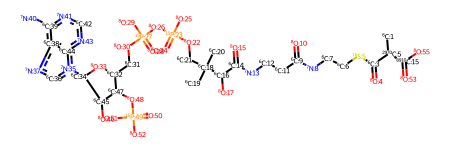

In [17]:
subs[1]

# troubleshooting prc mcs analysis

In [32]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole

import rdkit
print(rdkit.__version__)

2023.03.2


In [33]:
# Import all known reactions

from src.utils import load_json
from collections import defaultdict
from src.post_processing import Enzyme, DatabaseEntry

known_rxns = load_json("../data/mapping/known_rxns_swissprot_enzymes_plus_mcs_90_240310.json") # data/mapping/known_rxns_jni_w_enzyme_validation.json 
rule2krhash = defaultdict(list)
for k,v in known_rxns.items():

    # Convert enzymes and db entries to namedtuples
    enzymes = [Enzyme(*elt) for elt in v['enzymes']]
    v['enzymes'] = enzymes

    db_entries = [DatabaseEntry(*elt) for elt in v['db_entries']]
    v['db_entries'] = db_entries

In [34]:
for k, v in known_rxns.items():
    smarts = v['smarts']
    rxn = AllChem.ReactionFromSmarts(smarts, useSmiles=True)
    ras = rxn.GetReactingAtoms()
    print(ras)

    break
rxn

ValueError: ChemicalParserException: initReactantMatchers() must be called first

In [15]:
from ipywidgets import interact,fixed
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

cms = [Chem.MolFromSmiles(smi, sanitize=False) for smi in bad_subs]

@interact(idx=range(0,len(cms)),ms=fixed(cms))
def show_mol(idx,ms):
    d2d = rdMolDraw2D.MolDraw2DSVG(450,400)
    d2d.drawOptions().prepareMolsBeforeDrawing=False
    d2d.DrawMolecule(ms[idx])
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8), value=0), Output()), _d…

In [ ]:
bad_replacements = {'Cn1c[nH]c2nc(=O)[nH]c(=O)c21': 'CN1CNC2=C1C(=O)NC(=O)N2',
                    'Nc1[nH]c(=O)c2c(C(=O)O)cnc2[nH]1':'C1=C(C2=C(N1)N=C(NC2=O)N)C(=O)O',
                    'Nc1[nH]c(=O)c2ncnc2[nH]1':'C1=[NH+]C2=C(N1)C(=O)NC(=N2)N',
                    'NCc1cnc2[nH]c(N)[nH]c(=O)c12':'C1=C(C2=C(N1)N=C(NC2=O)N)CN',
                    'C=CC1=C(C)C2=CC3=C(C(O)CCC=C(C)CCC=C(C)CCC=C(C)C)C(C)=C4C=C5C(C=O)=C(CCC(=O)O)C6=N5[Fe]5(N7C(=CC1=N25)C(C)=C(CCC(=O)O)C7=C6)N43':'CC1=C(C2=CC3=NC(=CC4=C(C(=C([N-]4)C=C5C(=C(C(=N5)C=C1[N-]2)C(CCC=C(C)CCC=C(C)CCC=C(C)C)O)C)C=O)CCC(=O)O)C(=C3C)CCC(=O)O)C=C.[Fe+2]',
                    'Nc1[nH]c(=S)c2ncnc2[nH]1':'C1=[NH+]C2=C(N1)C(=S)NC(=N2)N',
                    'Nc1[nH]c(=O)c2c(CNC3C=CC(O)C3O)cnc2[nH]1':'C1=CC(C(C1NCC2=CNC3=C2C(=O)NC(=N3)N)O)O',
                    'Nc1[nH]c(=O)c2[nH]c(=O)nc2[nH]1':'C12=C(NC(=O)N1)N=C(NC2=O)N'
                    }

to_remove = ['Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(Nc3[nH]c(=O)c4ncnc4[nH]3)C(O)C2O)C(O)C1O']

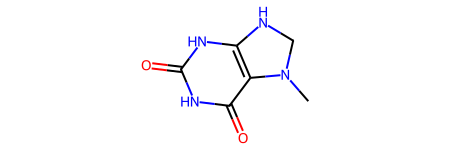

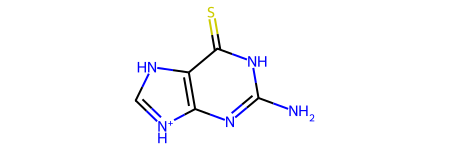

In [18]:
Chem.MolFromSmiles('C1=[NH+]C2=C(N1)C(=S)NC(=N2)N')

In [24]:
# Attempt to run SanitizeMol on all the substrates
# as G. Landrum recommended prior to getting reacting atoms
bad_subs_rxns = defaultdict(list)
new_subs_rxns = defaultdict(list)
in_out = set()
for k,v in known_rxns.items():
    smarts = v['smarts']
    subs = smarts.split('>>')[0].split('.') + smarts.split('>>')[1].split('.')
    subs = list(set(subs))

    for sub in subs:
        try:
            mol = Chem.MolFromSmiles(sub)
            Chem.SanitizeMol(mol)
            new_smi = Chem.MolToSmiles(mol)
            if new_smi != sub:
                new_subs_rxns[sub].append(k)
                in_out.add((sub, new_smi))
        except:
            bad_subs_rxns[sub].append(k)

[12:17:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:45] Can't kekulize mol.  Unkekulized atoms: 1 5 6 10 11 12
[12:17:45] Can't kekulize mol.  Unkekulized atoms: 1 5 6 10 11 12
[12:17:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[12:17:46] WARNING: not removing hydrogen atom with dummy atom ne

In [21]:
new_subs_rxns

defaultdict(list,
            {'Nc1nc[nH]c2ncnc12': ['R5918be0f375d57b65628aee840bd8b0a224333d173b0613532c2828d328fdb8f',
              'Re9f410c374259e72c126b90350465158cc1abdcd4bf913e165cbb47c1e6decc5',
              'R7edf2262e3a12735ff94c91e63405aa06f83a561f98a73fdce29cf46a97fcfeb',
              'Raf00e3d3ee2421b90ce82610129b796b2b019f9f029150753102dde7e35f4555',
              'R45c8de8eba514fac5770f33ce9e9b1d75c33c739f90aa4c8e18b863569f617a9',
              'Rd45c10963ce15c284e5c5aecef5a51b3e49bdd34303a942a0e8725e4ff755c59',
              'R14689c61badee984e9f1f6d31ce252ff6c000c3f1abd7b2e5becfe364e81584f',
              'Raf6db293568397be1dc06b5ab04781a7b3e684a45fa42b922db4acd50fd3f00b',
              'R2eea7cb108fb29a17573e354eedbae65878a9a720f7e4ff4b1611581b2e930d9',
              'R311c2ca8aa0568ebf81c94a4f8f290c0b3c0850cde6f456d4d2c1bb1fdd27b1c',
              'R559e9e6170c2945f7e7aaf29ee194c4312f6189ca39277bd7bdd29b5793d6edf',
              'R7c25f727c1816c0d10220e053ee32d7a

In [25]:
in_out

{('CC(=CCNc1nc[nH]c2ncnc12)CO', 'CC(=CCNc1nc[nH]c2ncnc1-2)CO'),
 ('CC(=CCNc1nc[nH]c2ncnc12)COC1OC(CO)C(O)C(O)C1O',
  'CC(=CCNc1nc[nH]c2ncnc1-2)COC1OC(CO)C(O)C(O)C1O'),
 ('CC(=CCNc1nc[nH]c2ncnc12)COC1OCC(O)C(O)C1O',
  'CC(=CCNc1nc[nH]c2ncnc1-2)COC1OCC(O)C(O)C1O'),
 ('CC(C)=CCNc1nc[nH]c2ncnc12', 'CC(C)=CCNc1nc[nH]c2ncnc1-2'),
 ('CSc1nc(N)[nH]c2ncnc12', 'CSc1nc(N)[nH]c2ncnc1-2'),
 ('CSc1nc[nH]c2ncnc12', 'CSc1nc[nH]c2ncnc1-2'),
 ('Nc1nc[nH]c2ncnc12', 'Nc1nc[nH]c2ncnc1-2'),
 ('OC1=C(O)C(=O)OC1C(O)CO', 'O=C1OC(C(O)CO)C(O)=C1O')}

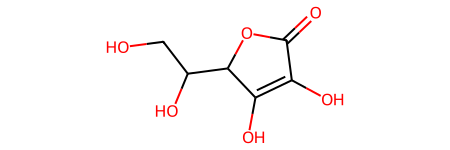

In [31]:
Chem.MolFromSmiles('OC1=C(O)C(=O)OC1C(O)CO')

In [37]:
am_issues = load_json("../artifacts/analysis_issues/atom_mapping_issues_known_rxns_swissprot_plus_mcs_90.json")
len([elt for elt in am_issues.values() if elt['imt_rules']])

2630